<a href="https://colab.research.google.com/github/KusalG05/Stock-Prophets/blob/main/StockMarket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.nn import functional as F
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc
import warnings
import os
warnings.filterwarnings('ignore')
from torch.optim import Adam
import random
from collections import Counter
import copy
import pandas as pd

In [27]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

In [28]:
!pip install yfinance

In [29]:
import yfinance as yf

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


##Downloading data

In [31]:
# maersk = yf.Ticker('^NSEI')
comp = [yf.Ticker('GOOG'), yf.Ticker('AAPL'), yf.Ticker('^NSEI'), yf.Ticker('^GSPC')]
history = [i.history(period='max', interval='1d') for i in comp]
data = {'GOOG': history[0], 'AAPL': history[1], '^NSEI': history[2], '^GSPC': history[3]}
history[0]

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2004-08-19 00:00:00-04:00,2.490664,2.591785,2.390042,2.499133,897427216,0.0,0.0
2004-08-20 00:00:00-04:00,2.515820,2.716817,2.503118,2.697639,458857488,0.0,0.0
2004-08-23 00:00:00-04:00,2.758411,2.826406,2.716070,2.724787,366857939,0.0,0.0
2004-08-24 00:00:00-04:00,2.770615,2.779581,2.579581,2.611960,306396159,0.0,0.0
2004-08-25 00:00:00-04:00,2.614201,2.689918,2.587302,2.640104,184645512,0.0,0.0
...,...,...,...,...,...,...,...
2023-11-17 00:00:00-05:00,137.820007,138.000000,135.479996,136.940002,25565300,0.0,0.0
2023-11-20 00:00:00-05:00,135.500000,138.425003,135.490005,137.919998,19569400,0.0,0.0
2023-11-21 00:00:00-05:00,137.940002,138.964996,137.705002,138.619995,17648100,0.0,0.0


In [32]:
!pip install keras

##Data Preprocessing


In [33]:
# We can add more features here
from keras.preprocessing.sequence import TimeseriesGenerator
def generate_series(data, value_num):
    close = data['Close']
    dividends = data['Dividends']

    tsg = TimeseriesGenerator(close, close,length=value_num,batch_size=len(close))
    tsg1 = TimeseriesGenerator(dividends, dividends,length=value_num,batch_size=len(dividends))
    i, t = tsg[0]
    i1, t1 = tsg1[0]
    comp = [i,i1]
    ans = [[[*k] for k in zip(*sublists)] for sublists in zip(*comp)]
    return np.array(ans), t

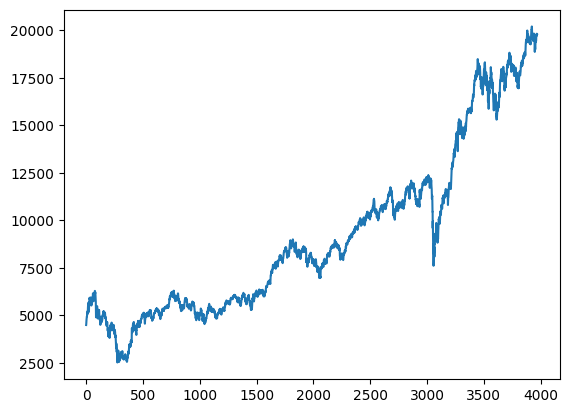

In [34]:
comp_name = '^NSEI' # company for which stocks to be predicted
X, Y = generate_series(data[comp_name], 100)
his1 = data[comp_name].reset_index()['Close']
plt.plot(his1) # plotting the entire data we have(train, validation, test)

In [35]:
from sklearn.preprocessing import MinMaxScaler
scaler = [MinMaxScaler(feature_range=(0, 1)) for _ in range(X.shape[2])]
X = [scaler[i].fit_transform(X[:,:,i]) for i in range(X.shape[2])]
Y = scaler[0].fit_transform(Y.reshape((-1,1)))
X = torch.tensor([[[*k] for k in zip(*sublists)] for sublists in zip(*X)])
X = torch.tensor(X, dtype = torch.float)
Y = torch.tensor(Y, dtype = torch.float)

In [36]:
def split_data(X, Y, p):
    lookback = int(p*len(X))
    X_test = X[-1*lookback:]
    Y_test = Y[-1*lookback:]
    X_val = X[-2*lookback:-1*lookback]
    Y_val = Y[-2*lookback:-1*lookback]
    X_train = X[:-2*lookback]
    Y_train = Y[:-2*lookback]
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [37]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = split_data(X,Y, 0.2)

#converting data into tensor batches
from torch.utils.data import DataLoader, TensorDataset

vectorized_train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(vectorized_train_dataset, batch_size=128, shuffle=True)

vectorized_val_dataset = TensorDataset(X_val, Y_val)
val_loader = DataLoader(vectorized_val_dataset, batch_size=128, shuffle=False)

## LSTM Model

In [38]:
from torch import nn
from torch.nn import functional as F

class StockPredictor(nn.Module):
    def __init__(self,input_dim, n_layers, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_size = input_dim, hidden_size = hidden_dim, num_layers = n_layers, batch_first = True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(p = 0.3)
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

    def forward(self, X_batch):
        hidden, carry = torch.randn(self.n_layers, len(X_batch), self.hidden_dim).to(device), torch.randn(self.n_layers, len(X_batch), self.hidden_dim).to(device)
        output, (hidden, carry) = self.lstm(X_batch)
        return self.linear(self.dropout(output[:,-1, :]))

## Training models like LSTM's, GRU's

In [39]:
def train(model, loss_fn, optimizer, train_loader, val_loader, epochs=10): # training the model using validation and train data
  set_seed(42)
  best_checkpoint = None
  val_prev_loss = 10000000.0
  avg_losses = []

  for i in range(1, epochs+1):
    losses = []
    print("Current epoch: ", i)
    model.train()
    ## Training step
    for X, Y in tqdm(train_loader):
        Y_preds = model(X.to(device))
        loss = loss_fn(Y_preds, Y.to(device))
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_losses.append(torch.tensor(losses).mean().item())
    print("Training Loss:", torch.tensor(losses).mean().item())
    ## Validation step
    val_losses = []
    model.eval()
    with torch.no_grad():
        for X, Y in tqdm(val_loader):
            Y_preds = model(X.to(device))
            loss = loss_fn(Y_preds, Y.to(device))
            val_losses.append(loss.item())
    print("Validation Loss:",torch.tensor(val_losses).mean().item())
    ## Selecting best model
    if torch.tensor(val_losses).mean().item() < val_prev_loss:
        print("checkpointing current model")
        best_checkpoint = copy.deepcopy(model)
        val_prev_loss = torch.tensor(val_losses).mean().item()
  return best_checkpoint, model, avg_losses

In [40]:
from torch.optim import Adam

epochs = 100
learning_rate = 5e-3
hidden_dim = 32
n_layers=1
input_dim = X_train.shape[2]

loss_fn = nn.MSELoss().to(device)
model = StockPredictor(input_dim, n_layers, hidden_dim).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

## training using validation and train data
best_checkpoint, last_checkpoint, avg_losses = train(model, loss_fn, optimizer, train_loader, val_loader, epochs)

Current epoch:  1


100%|██████████| 19/19 [00:00<00:00, 295.62it/s]


Training Loss: 0.009897510521113873


100%|██████████| 7/7 [00:00<00:00, 391.54it/s]


Validation Loss: 0.043361958116292953
checkpointing current model
Current epoch:  2


100%|██████████| 19/19 [00:00<00:00, 293.89it/s]


Training Loss: 0.003167724469676614


100%|██████████| 7/7 [00:00<00:00, 575.36it/s]


Validation Loss: 0.0027695924509316683
checkpointing current model
Current epoch:  3


100%|██████████| 19/19 [00:00<00:00, 294.01it/s]


Training Loss: 0.0009732458274811506


100%|██████████| 7/7 [00:00<00:00, 525.46it/s]


Validation Loss: 0.00021669721172656864
checkpointing current model
Current epoch:  4


100%|██████████| 19/19 [00:00<00:00, 296.45it/s]


Training Loss: 0.0005869112210348248


100%|██████████| 7/7 [00:00<00:00, 493.53it/s]

Validation Loss: 0.00019484534277580678
checkpointing current model


Current epoch:  5


100%|██████████| 19/19 [00:00<00:00, 304.18it/s]


Training Loss: 0.00045081545249558985


100%|██████████| 7/7 [00:00<00:00, 566.29it/s]


Validation Loss: 0.00021543202456086874
Current epoch:  6


100%|██████████| 19/19 [00:00<00:00, 250.47it/s]


Training Loss: 0.0004220393602736294


100%|██████████| 7/7 [00:00<00:00, 480.84it/s]


Validation Loss: 0.000323319633025676
Current epoch:  7


100%|██████████| 19/19 [00:00<00:00, 298.91it/s]


Training Loss: 0.00033724686363711953


100%|██████████| 7/7 [00:00<00:00, 504.62it/s]


Validation Loss: 0.0002601358573883772
Current epoch:  8


100%|██████████| 19/19 [00:00<00:00, 285.97it/s]


Training Loss: 0.00032029228168539703


100%|██████████| 7/7 [00:00<00:00, 495.04it/s]


Validation Loss: 0.0005532737704925239
Current epoch:  9


100%|██████████| 19/19 [00:00<00:00, 280.90it/s]


Training Loss: 0.00028970642597414553


100%|██████████| 7/7 [00:00<00:00, 524.24it/s]


Validation Loss: 0.00025896370061673224
Current epoch:  10


100%|██████████| 19/19 [00:00<00:00, 288.61it/s]


Training Loss: 0.00030905124731361866


100%|██████████| 7/7 [00:00<00:00, 598.23it/s]


Validation Loss: 0.0004927163245156407
Current epoch:  11


100%|██████████| 19/19 [00:00<00:00, 264.39it/s]


Training Loss: 0.00029020861256867647


100%|██████████| 7/7 [00:00<00:00, 470.79it/s]


Validation Loss: 0.0002165969490306452
Current epoch:  12


100%|██████████| 19/19 [00:00<00:00, 277.47it/s]


Training Loss: 0.00029607280157506466


100%|██████████| 7/7 [00:00<00:00, 492.26it/s]


Validation Loss: 0.00047100670053623617
Current epoch:  13


100%|██████████| 19/19 [00:00<00:00, 286.33it/s]


Training Loss: 0.00025845583877526224


100%|██████████| 7/7 [00:00<00:00, 474.45it/s]


Validation Loss: 0.00016503782535437495
checkpointing current model
Current epoch:  14


100%|██████████| 19/19 [00:00<00:00, 237.44it/s]


Training Loss: 0.00022678128152620047


100%|██████████| 7/7 [00:00<00:00, 368.75it/s]


Validation Loss: 0.0007679390837438405
Current epoch:  15


100%|██████████| 19/19 [00:00<00:00, 196.68it/s]


Training Loss: 0.00023458940268028527


100%|██████████| 7/7 [00:00<00:00, 299.83it/s]


Validation Loss: 0.00018257752526551485
Current epoch:  16


100%|██████████| 19/19 [00:00<00:00, 199.68it/s]


Training Loss: 0.0002216960274381563


100%|██████████| 7/7 [00:00<00:00, 450.16it/s]


Validation Loss: 0.00026615828392095864
Current epoch:  17


100%|██████████| 19/19 [00:00<00:00, 301.44it/s]


Training Loss: 0.0002168715000152588


100%|██████████| 7/7 [00:00<00:00, 514.18it/s]


Validation Loss: 0.000252224737778306
Current epoch:  18


100%|██████████| 19/19 [00:00<00:00, 291.21it/s]


Training Loss: 0.00020206459157634526


100%|██████████| 7/7 [00:00<00:00, 516.72it/s]


Validation Loss: 0.00042987935012206435
Current epoch:  19


100%|██████████| 19/19 [00:00<00:00, 285.85it/s]


Training Loss: 0.00019542247173376381


100%|██████████| 7/7 [00:00<00:00, 495.93it/s]


Validation Loss: 0.00015747160068713129
checkpointing current model
Current epoch:  20


100%|██████████| 19/19 [00:00<00:00, 288.48it/s]


Training Loss: 0.0001982142130145803


100%|██████████| 7/7 [00:00<00:00, 551.71it/s]


Validation Loss: 0.00024890684289857745
Current epoch:  21


100%|██████████| 19/19 [00:00<00:00, 276.18it/s]


Training Loss: 0.00020143575966358185


100%|██████████| 7/7 [00:00<00:00, 474.99it/s]


Validation Loss: 0.0005042596603743732
Current epoch:  22


100%|██████████| 19/19 [00:00<00:00, 279.13it/s]


Training Loss: 0.0002170941879739985


100%|██████████| 7/7 [00:00<00:00, 552.54it/s]


Validation Loss: 0.00018296545022167265
Current epoch:  23


100%|██████████| 19/19 [00:00<00:00, 286.45it/s]


Training Loss: 0.0002070323535008356


100%|██████████| 7/7 [00:00<00:00, 499.38it/s]


Validation Loss: 0.00015625605010427535
checkpointing current model
Current epoch:  24


100%|██████████| 19/19 [00:00<00:00, 311.40it/s]


Training Loss: 0.00020608918566722423


100%|██████████| 7/7 [00:00<00:00, 495.61it/s]


Validation Loss: 0.00026722491020336747
Current epoch:  25


100%|██████████| 19/19 [00:00<00:00, 253.10it/s]


Training Loss: 0.00020939834939781576


100%|██████████| 7/7 [00:00<00:00, 559.45it/s]


Validation Loss: 0.000636506243608892
Current epoch:  26


100%|██████████| 19/19 [00:00<00:00, 269.43it/s]


Training Loss: 0.00020691454119514674


100%|██████████| 7/7 [00:00<00:00, 543.93it/s]


Validation Loss: 0.00022528173576574773
Current epoch:  27


100%|██████████| 19/19 [00:00<00:00, 280.00it/s]


Training Loss: 0.00020078924717381597


100%|██████████| 7/7 [00:00<00:00, 474.42it/s]


Validation Loss: 0.0003046661149710417
Current epoch:  28


100%|██████████| 19/19 [00:00<00:00, 273.40it/s]


Training Loss: 0.00019366345077287406


100%|██████████| 7/7 [00:00<00:00, 487.35it/s]


Validation Loss: 0.0002555006940383464
Current epoch:  29


100%|██████████| 19/19 [00:00<00:00, 248.37it/s]


Training Loss: 0.00019412128312978894


100%|██████████| 7/7 [00:00<00:00, 497.69it/s]


Validation Loss: 0.00015127056394703686
checkpointing current model
Current epoch:  30


100%|██████████| 19/19 [00:00<00:00, 271.01it/s]


Training Loss: 0.0001977141946554184


100%|██████████| 7/7 [00:00<00:00, 503.69it/s]


Validation Loss: 0.0002023614215431735
Current epoch:  31


100%|██████████| 19/19 [00:00<00:00, 292.25it/s]


Training Loss: 0.0001939725043484941


100%|██████████| 7/7 [00:00<00:00, 481.16it/s]


Validation Loss: 0.0004251511418260634
Current epoch:  32


100%|██████████| 19/19 [00:00<00:00, 250.91it/s]


Training Loss: 0.00021647730318363756


100%|██████████| 7/7 [00:00<00:00, 335.04it/s]


Validation Loss: 0.00020580818818416446
Current epoch:  33


100%|██████████| 19/19 [00:00<00:00, 193.73it/s]


Training Loss: 0.00020910373132210225


100%|██████████| 7/7 [00:00<00:00, 380.81it/s]


Validation Loss: 0.00020749299437738955
Current epoch:  34


100%|██████████| 19/19 [00:00<00:00, 193.15it/s]


Training Loss: 0.00020193259115330875


100%|██████████| 7/7 [00:00<00:00, 374.00it/s]


Validation Loss: 0.0002612996322568506
Current epoch:  35


100%|██████████| 19/19 [00:00<00:00, 216.62it/s]


Training Loss: 0.00018025489407591522


100%|██████████| 7/7 [00:00<00:00, 349.15it/s]


Validation Loss: 0.0002990149368997663
Current epoch:  36


100%|██████████| 19/19 [00:00<00:00, 216.30it/s]


Training Loss: 0.0001979904482141137


100%|██████████| 7/7 [00:00<00:00, 350.45it/s]


Validation Loss: 0.0001427536190021783
checkpointing current model
Current epoch:  37


100%|██████████| 19/19 [00:00<00:00, 217.54it/s]


Training Loss: 0.00020820349163841456


100%|██████████| 7/7 [00:00<00:00, 400.97it/s]


Validation Loss: 0.00012408304610289633
checkpointing current model
Current epoch:  38


100%|██████████| 19/19 [00:00<00:00, 209.75it/s]


Training Loss: 0.00019114228780381382


100%|██████████| 7/7 [00:00<00:00, 390.23it/s]


Validation Loss: 0.0005645093624480069
Current epoch:  39


100%|██████████| 19/19 [00:00<00:00, 202.11it/s]


Training Loss: 0.00019007046648766845


100%|██████████| 7/7 [00:00<00:00, 405.78it/s]


Validation Loss: 0.00013259284605737776
Current epoch:  40


100%|██████████| 19/19 [00:00<00:00, 217.66it/s]


Training Loss: 0.00018687493866309524


100%|██████████| 7/7 [00:00<00:00, 399.95it/s]


Validation Loss: 0.0001161621548817493
checkpointing current model
Current epoch:  41


100%|██████████| 19/19 [00:00<00:00, 218.98it/s]


Training Loss: 0.00019344476459082216


100%|██████████| 7/7 [00:00<00:00, 388.60it/s]


Validation Loss: 0.0003363374271430075
Current epoch:  42


100%|██████████| 19/19 [00:00<00:00, 214.41it/s]


Training Loss: 0.00017835662583820522


100%|██████████| 7/7 [00:00<00:00, 408.85it/s]


Validation Loss: 0.0001547549181850627
Current epoch:  43


100%|██████████| 19/19 [00:00<00:00, 192.59it/s]


Training Loss: 0.0001921235816553235


100%|██████████| 7/7 [00:00<00:00, 313.20it/s]


Validation Loss: 0.0002266695082653314
Current epoch:  44


100%|██████████| 19/19 [00:00<00:00, 98.91it/s]


Training Loss: 0.00017770130943972617


100%|██████████| 7/7 [00:00<00:00, 156.89it/s]


Validation Loss: 0.00025936024030670524
Current epoch:  45


100%|██████████| 19/19 [00:00<00:00, 113.43it/s]


Training Loss: 0.0001903982920339331


100%|██████████| 7/7 [00:00<00:00, 156.21it/s]


Validation Loss: 0.00013612273323815316
Current epoch:  46


100%|██████████| 19/19 [00:00<00:00, 104.36it/s]


Training Loss: 0.0001938454806804657


100%|██████████| 7/7 [00:00<00:00, 272.95it/s]


Validation Loss: 0.0001302497403230518
Current epoch:  47


100%|██████████| 19/19 [00:00<00:00, 131.72it/s]


Training Loss: 0.0001880764466477558


100%|██████████| 7/7 [00:00<00:00, 171.39it/s]


Validation Loss: 0.0002161706070182845
Current epoch:  48


100%|██████████| 19/19 [00:00<00:00, 102.70it/s]


Training Loss: 0.0001935792970471084


100%|██████████| 7/7 [00:00<00:00, 152.79it/s]


Validation Loss: 0.00011458535300334916
checkpointing current model
Current epoch:  49


100%|██████████| 19/19 [00:00<00:00, 88.86it/s]


Training Loss: 0.00017498161469120532


100%|██████████| 7/7 [00:00<00:00, 144.21it/s]


Validation Loss: 0.00011988150799879804
Current epoch:  50


100%|██████████| 19/19 [00:00<00:00, 114.14it/s]


Training Loss: 0.00017358626064378768


100%|██████████| 7/7 [00:00<00:00, 143.61it/s]


Validation Loss: 0.00010216101509286091
checkpointing current model
Current epoch:  51


100%|██████████| 19/19 [00:00<00:00, 140.01it/s]


Training Loss: 0.00017416858463548124


100%|██████████| 7/7 [00:00<00:00, 184.15it/s]


Validation Loss: 0.00016144233813975006
Current epoch:  52


100%|██████████| 19/19 [00:00<00:00, 97.75it/s] 


Training Loss: 0.0001698600099189207


100%|██████████| 7/7 [00:00<00:00, 153.86it/s]


Validation Loss: 0.0004347508947830647
Current epoch:  53


100%|██████████| 19/19 [00:00<00:00, 90.31it/s]


Training Loss: 0.0002070025948341936


100%|██████████| 7/7 [00:00<00:00, 78.45it/s]


Validation Loss: 0.00010829017264768481
Current epoch:  54


100%|██████████| 19/19 [00:00<00:00, 73.02it/s]


Training Loss: 0.0002016515500145033


100%|██████████| 7/7 [00:00<00:00, 111.67it/s]


Validation Loss: 0.00014258225564844906
Current epoch:  55


100%|██████████| 19/19 [00:00<00:00, 73.51it/s]


Training Loss: 0.00017691939137876034


100%|██████████| 7/7 [00:00<00:00, 162.77it/s]


Validation Loss: 0.0003676712221931666
Current epoch:  56


100%|██████████| 19/19 [00:00<00:00, 99.95it/s]


Training Loss: 0.0001802861806936562


100%|██████████| 7/7 [00:00<00:00, 160.87it/s]


Validation Loss: 0.0002537397958803922
Current epoch:  57


100%|██████████| 19/19 [00:00<00:00, 108.24it/s]


Training Loss: 0.00018172893032897264


100%|██████████| 7/7 [00:00<00:00, 267.54it/s]


Validation Loss: 0.0002559448766987771
Current epoch:  58


100%|██████████| 19/19 [00:00<00:00, 153.96it/s]


Training Loss: 0.0001894962479127571


100%|██████████| 7/7 [00:00<00:00, 369.12it/s]


Validation Loss: 0.00010271107021253556
Current epoch:  59


100%|██████████| 19/19 [00:00<00:00, 91.09it/s]


Training Loss: 0.00019140291260555387


100%|██████████| 7/7 [00:00<00:00, 280.01it/s]


Validation Loss: 0.0003243530518375337
Current epoch:  60


100%|██████████| 19/19 [00:00<00:00, 101.67it/s]


Training Loss: 0.0001762510946718976


100%|██████████| 7/7 [00:00<00:00, 403.68it/s]


Validation Loss: 0.000101203411759343
checkpointing current model
Current epoch:  61


100%|██████████| 19/19 [00:00<00:00, 178.25it/s]


Training Loss: 0.00017945581930689514


100%|██████████| 7/7 [00:00<00:00, 397.19it/s]


Validation Loss: 0.00012327669537626207
Current epoch:  62


100%|██████████| 19/19 [00:00<00:00, 169.08it/s]


Training Loss: 0.00017780729103833437


100%|██████████| 7/7 [00:00<00:00, 392.38it/s]


Validation Loss: 9.594455332262442e-05
checkpointing current model
Current epoch:  63


100%|██████████| 19/19 [00:00<00:00, 166.96it/s]


Training Loss: 0.0001670106576057151


100%|██████████| 7/7 [00:00<00:00, 350.62it/s]


Validation Loss: 0.0004395481082610786
Current epoch:  64


100%|██████████| 19/19 [00:00<00:00, 133.37it/s]


Training Loss: 0.00018777765217237175


100%|██████████| 7/7 [00:00<00:00, 216.32it/s]


Validation Loss: 0.00016928119293879718
Current epoch:  65


100%|██████████| 19/19 [00:00<00:00, 196.88it/s]


Training Loss: 0.0001666793687036261


100%|██████████| 7/7 [00:00<00:00, 170.87it/s]


Validation Loss: 0.0001443887158529833
Current epoch:  66


100%|██████████| 19/19 [00:00<00:00, 127.45it/s]


Training Loss: 0.0001776596618583426


100%|██████████| 7/7 [00:00<00:00, 386.29it/s]


Validation Loss: 0.0002784403332043439
Current epoch:  67


100%|██████████| 19/19 [00:00<00:00, 220.56it/s]


Training Loss: 0.00019407831132411957


100%|██████████| 7/7 [00:00<00:00, 373.54it/s]


Validation Loss: 0.000142803430208005
Current epoch:  68


100%|██████████| 19/19 [00:00<00:00, 118.85it/s]


Training Loss: 0.00020361351198516786


100%|██████████| 7/7 [00:00<00:00, 170.98it/s]


Validation Loss: 0.00027487464831210673
Current epoch:  69


100%|██████████| 19/19 [00:00<00:00, 175.81it/s]


Training Loss: 0.00017563081928528845


100%|██████████| 7/7 [00:00<00:00, 342.40it/s]


Validation Loss: 9.874364332063124e-05
Current epoch:  70


100%|██████████| 19/19 [00:00<00:00, 145.15it/s]


Training Loss: 0.00018480005383025855


100%|██████████| 7/7 [00:00<00:00, 385.23it/s]


Validation Loss: 0.0001877923059510067
Current epoch:  71


100%|██████████| 19/19 [00:00<00:00, 183.09it/s]


Training Loss: 0.00020154123194515705


100%|██████████| 7/7 [00:00<00:00, 312.87it/s]


Validation Loss: 8.427366992691532e-05
checkpointing current model
Current epoch:  72


100%|██████████| 19/19 [00:00<00:00, 197.82it/s]


Training Loss: 0.00016683017020113766


100%|██████████| 7/7 [00:00<00:00, 356.53it/s]


Validation Loss: 8.361657819477841e-05
checkpointing current model
Current epoch:  73


100%|██████████| 19/19 [00:00<00:00, 160.01it/s]


Training Loss: 0.00020126883464399725


100%|██████████| 7/7 [00:00<00:00, 255.31it/s]


Validation Loss: 8.250805694842711e-05
checkpointing current model
Current epoch:  74


100%|██████████| 19/19 [00:00<00:00, 167.08it/s]


Training Loss: 0.00018396356608718634


100%|██████████| 7/7 [00:00<00:00, 115.85it/s]


Validation Loss: 0.0001830905384849757
Current epoch:  75


100%|██████████| 19/19 [00:00<00:00, 109.81it/s]


Training Loss: 0.00016341129958163947


100%|██████████| 7/7 [00:00<00:00, 326.75it/s]


Validation Loss: 0.00033427512971684337
Current epoch:  76


100%|██████████| 19/19 [00:00<00:00, 105.50it/s]


Training Loss: 0.0001750490046106279


100%|██████████| 7/7 [00:00<00:00, 303.94it/s]


Validation Loss: 0.00015055391122587025
Current epoch:  77


100%|██████████| 19/19 [00:00<00:00, 163.66it/s]


Training Loss: 0.00017059284436982125


100%|██████████| 7/7 [00:00<00:00, 156.04it/s]


Validation Loss: 0.000298633094644174
Current epoch:  78


100%|██████████| 19/19 [00:00<00:00, 121.67it/s]


Training Loss: 0.0001734235556796193


100%|██████████| 7/7 [00:00<00:00, 386.75it/s]


Validation Loss: 8.94707627594471e-05
Current epoch:  79


100%|██████████| 19/19 [00:00<00:00, 209.25it/s]


Training Loss: 0.00017808536358643323


100%|██████████| 7/7 [00:00<00:00, 390.28it/s]


Validation Loss: 0.00014267662481870502
Current epoch:  80


100%|██████████| 19/19 [00:00<00:00, 161.41it/s]


Training Loss: 0.00018454516248311847


100%|██████████| 7/7 [00:00<00:00, 279.78it/s]


Validation Loss: 0.0001001158234430477
Current epoch:  81


100%|██████████| 19/19 [00:00<00:00, 182.09it/s]


Training Loss: 0.00018890727369580418


100%|██████████| 7/7 [00:00<00:00, 150.70it/s]


Validation Loss: 0.0001383278431603685
Current epoch:  82


100%|██████████| 19/19 [00:00<00:00, 165.39it/s]


Training Loss: 0.00017317589663434774


100%|██████████| 7/7 [00:00<00:00, 403.04it/s]


Validation Loss: 0.00036733411252498627
Current epoch:  83


100%|██████████| 19/19 [00:00<00:00, 123.93it/s]


Training Loss: 0.0001658387336647138


100%|██████████| 7/7 [00:00<00:00, 272.96it/s]


Validation Loss: 7.972658204380423e-05
checkpointing current model
Current epoch:  84


100%|██████████| 19/19 [00:00<00:00, 189.99it/s]


Training Loss: 0.00016135895566549152


100%|██████████| 7/7 [00:00<00:00, 371.56it/s]


Validation Loss: 8.182916644727811e-05
Current epoch:  85


100%|██████████| 19/19 [00:00<00:00, 169.80it/s]


Training Loss: 0.00016386675997637212


100%|██████████| 7/7 [00:00<00:00, 357.97it/s]


Validation Loss: 0.0002812530437950045
Current epoch:  86


100%|██████████| 19/19 [00:00<00:00, 170.17it/s]


Training Loss: 0.00018478449783287942


100%|██████████| 7/7 [00:00<00:00, 380.86it/s]


Validation Loss: 0.0002621060120873153
Current epoch:  87


100%|██████████| 19/19 [00:00<00:00, 133.30it/s]


Training Loss: 0.00018128920055460185


100%|██████████| 7/7 [00:00<00:00, 186.89it/s]


Validation Loss: 0.00011087100574513897
Current epoch:  88


100%|██████████| 19/19 [00:00<00:00, 118.67it/s]


Training Loss: 0.00017785330419428647


100%|██████████| 7/7 [00:00<00:00, 310.07it/s]


Validation Loss: 0.0001956998894456774
Current epoch:  89


100%|██████████| 19/19 [00:00<00:00, 181.77it/s]


Training Loss: 0.00017450563609600067


100%|██████████| 7/7 [00:00<00:00, 361.30it/s]


Validation Loss: 0.00022756266116630286
Current epoch:  90


100%|██████████| 19/19 [00:00<00:00, 191.01it/s]


Training Loss: 0.0001624950673431158


100%|██████████| 7/7 [00:00<00:00, 323.71it/s]


Validation Loss: 7.471112621715292e-05
checkpointing current model
Current epoch:  91


100%|██████████| 19/19 [00:00<00:00, 108.25it/s]


Training Loss: 0.00018056525732390583


100%|██████████| 7/7 [00:00<00:00, 279.04it/s]


Validation Loss: 0.00011477388034109026
Current epoch:  92


100%|██████████| 19/19 [00:00<00:00, 205.48it/s]


Training Loss: 0.0001610944455023855


100%|██████████| 7/7 [00:00<00:00, 335.99it/s]


Validation Loss: 7.527291018050164e-05
Current epoch:  93


100%|██████████| 19/19 [00:00<00:00, 190.04it/s]


Training Loss: 0.00017396605107933283


100%|██████████| 7/7 [00:00<00:00, 230.79it/s]


Validation Loss: 7.620127871632576e-05
Current epoch:  94


100%|██████████| 19/19 [00:00<00:00, 157.12it/s]


Training Loss: 0.0001617523084860295


100%|██████████| 7/7 [00:00<00:00, 259.32it/s]


Validation Loss: 7.838902092771605e-05
Current epoch:  95


100%|██████████| 19/19 [00:00<00:00, 189.64it/s]


Training Loss: 0.0001903550000861287


100%|██████████| 7/7 [00:00<00:00, 239.45it/s]


Validation Loss: 0.00010788974759634584
Current epoch:  96


100%|██████████| 19/19 [00:00<00:00, 142.63it/s]


Training Loss: 0.00018683349480852485


100%|██████████| 7/7 [00:00<00:00, 323.96it/s]


Validation Loss: 0.0001090691439458169
Current epoch:  97


100%|██████████| 19/19 [00:00<00:00, 190.87it/s]


Training Loss: 0.00018666281539481133


100%|██████████| 7/7 [00:00<00:00, 306.83it/s]


Validation Loss: 0.00030763939139433205
Current epoch:  98


100%|██████████| 19/19 [00:00<00:00, 80.18it/s]


Training Loss: 0.0002067986351903528


100%|██████████| 7/7 [00:00<00:00, 295.41it/s]


Validation Loss: 0.00019936845637857914
Current epoch:  99


100%|██████████| 19/19 [00:00<00:00, 118.37it/s]


Training Loss: 0.00018993135017808527


100%|██████████| 7/7 [00:00<00:00, 137.11it/s]


Validation Loss: 0.00011112696665804833
Current epoch:  100


100%|██████████| 19/19 [00:00<00:00, 104.89it/s]


Training Loss: 0.00017299421597272158


100%|██████████| 7/7 [00:00<00:00, 223.11it/s]

Validation Loss: 8.734774746699259e-05


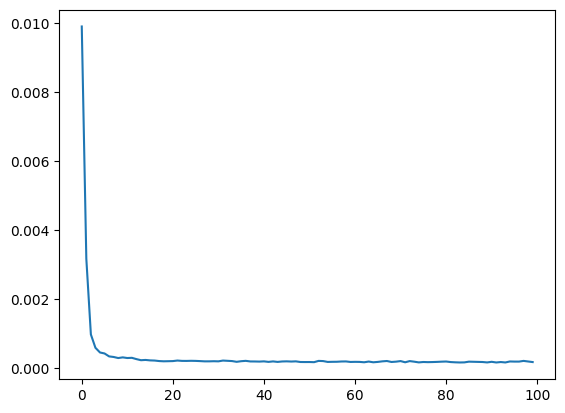

In [41]:
plt.plot(avg_losses) #plot of training losses

##Predicting test data using LSTM

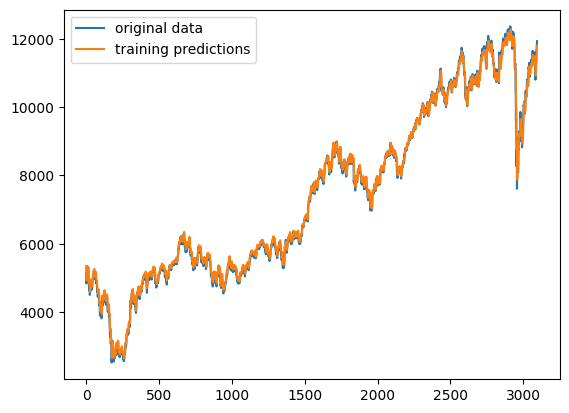

In [42]:
np.random.seed(48)
model.eval()
with torch.no_grad():
  closing_price = model(X_test.to(device))
  closing_price = scaler[0].inverse_transform(closing_price.cpu().numpy())
  training_price = model(X_train.to(device))
  valid_price = model(X_val.to(device))
  training_price = scaler[0].inverse_transform(training_price.cpu().numpy())
  valid_price = scaler[0].inverse_transform(valid_price.cpu().numpy())

training_price = [x[0] for x in training_price]
valid_price = [x[0] for x in valid_price]
plt.plot(list(scaler[0].inverse_transform(Y_train).tolist()+scaler[0].inverse_transform(Y_val).tolist()),label='original data')
plt.plot(list(training_price)+list(valid_price),label='training predictions')
plt.legend()
plt.show()

In [43]:
### Calculate RMSE performance metrics
Y_test = scaler[0].inverse_transform(Y_test)
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_test,closing_price))

513.9663368567582

##Plotting predicted data using LSTM

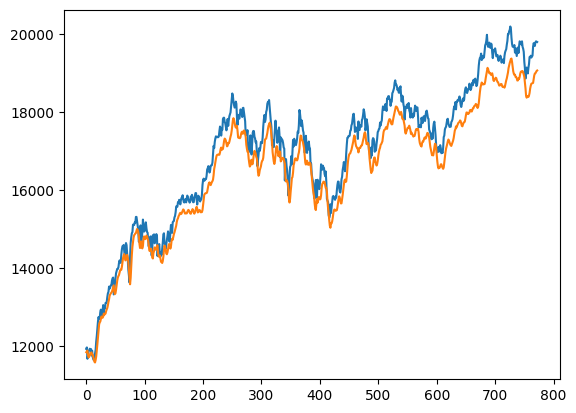

In [44]:
plt.plot(Y_test.tolist())
plt.plot(closing_price)
plt.show()

## GRU Model

In [45]:
class StockPredictor_v2(nn.Module):
    def __init__(self,input_dim, n_layers, hidden_dim):
        super().__init__()
        self.gru = nn.GRU(input_size = input_dim, hidden_size = hidden_dim, num_layers = n_layers, batch_first = True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(p = 0.3)
        self.num_layers = n_layers
        self.hidden_dim = hidden_dim

    def forward(self, X_batch):
        hidden = torch.zeros(self.num_layers, X_batch.size(0), self.hidden_dim).requires_grad_().to(device)
        output, (hidden) = self.gru(X_batch.to(device), (hidden.detach()))
        return self.linear(self.dropout(output[:,-1, :]))

In [46]:
from torch.optim import Adam

epochs = 100
learning_rate = 5e-3
hidden_dim = 32
n_layers=1
input_dim = 2

loss_fn = nn.MSELoss().to(device)
model = StockPredictor_v2(input_dim, n_layers, hidden_dim).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

## training using validation and train data
best_checkpoint, last_checkpoint, avg_losses = train(model, loss_fn, optimizer, train_loader, val_loader, epochs)

Current epoch:  1


100%|██████████| 19/19 [00:00<00:00, 130.40it/s]


Training Loss: 0.01258786115795374


100%|██████████| 7/7 [00:00<00:00, 234.09it/s]


Validation Loss: 0.040093887597322464
checkpointing current model
Current epoch:  2


100%|██████████| 19/19 [00:00<00:00, 164.20it/s]


Training Loss: 0.004832069389522076


100%|██████████| 7/7 [00:00<00:00, 274.07it/s]


Validation Loss: 0.0022049059625715017
checkpointing current model
Current epoch:  3


100%|██████████| 19/19 [00:00<00:00, 126.15it/s]


Training Loss: 0.001745877438224852


100%|██████████| 7/7 [00:00<00:00, 144.90it/s]


Validation Loss: 0.0015744899865239859
checkpointing current model
Current epoch:  4


100%|██████████| 19/19 [00:00<00:00, 80.97it/s]


Training Loss: 0.001156023470684886


100%|██████████| 7/7 [00:00<00:00, 186.29it/s]


Validation Loss: 0.0003801014390774071
checkpointing current model
Current epoch:  5


100%|██████████| 19/19 [00:00<00:00, 88.62it/s] 


Training Loss: 0.0008954613585956395


100%|██████████| 7/7 [00:00<00:00, 183.39it/s]


Validation Loss: 0.00035610972554422915
checkpointing current model
Current epoch:  6


100%|██████████| 19/19 [00:00<00:00, 105.75it/s]


Training Loss: 0.0007557849166914821


100%|██████████| 7/7 [00:00<00:00, 140.94it/s]


Validation Loss: 0.00017511167970951647
checkpointing current model
Current epoch:  7


100%|██████████| 19/19 [00:00<00:00, 88.02it/s]


Training Loss: 0.0006292098551057279


100%|██████████| 7/7 [00:00<00:00, 121.27it/s]


Validation Loss: 0.00023112328199204057
Current epoch:  8


100%|██████████| 19/19 [00:00<00:00, 62.12it/s]


Training Loss: 0.0005885697901248932


100%|██████████| 7/7 [00:00<00:00, 179.65it/s]


Validation Loss: 0.0001285297330468893
checkpointing current model
Current epoch:  9


100%|██████████| 19/19 [00:00<00:00, 87.70it/s]


Training Loss: 0.0005149655044078827


100%|██████████| 7/7 [00:00<00:00, 168.87it/s]


Validation Loss: 0.00017810020653996617
Current epoch:  10


100%|██████████| 19/19 [00:00<00:00, 78.22it/s]


Training Loss: 0.0005129682831466198


100%|██████████| 7/7 [00:00<00:00, 108.49it/s]


Validation Loss: 0.00014586922770831734
Current epoch:  11


100%|██████████| 19/19 [00:00<00:00, 81.28it/s]


Training Loss: 0.00044448429252952337


100%|██████████| 7/7 [00:00<00:00, 122.23it/s]


Validation Loss: 0.000142219229019247
Current epoch:  12


100%|██████████| 19/19 [00:00<00:00, 59.07it/s]


Training Loss: 0.0003855108516290784


100%|██████████| 7/7 [00:00<00:00, 124.04it/s]


Validation Loss: 9.079022129299119e-05
checkpointing current model
Current epoch:  13


100%|██████████| 19/19 [00:00<00:00, 62.90it/s]


Training Loss: 0.000400084798457101


100%|██████████| 7/7 [00:00<00:00, 227.26it/s]


Validation Loss: 0.00043369451304897666
Current epoch:  14


100%|██████████| 19/19 [00:00<00:00, 91.88it/s] 


Training Loss: 0.00034585376852191985


100%|██████████| 7/7 [00:00<00:00, 146.25it/s]


Validation Loss: 0.00018657946202438325
Current epoch:  15


100%|██████████| 19/19 [00:00<00:00, 99.89it/s] 


Training Loss: 0.00029922378598712385


100%|██████████| 7/7 [00:00<00:00, 210.86it/s]


Validation Loss: 0.00025684080901555717
Current epoch:  16


100%|██████████| 19/19 [00:00<00:00, 60.57it/s]


Training Loss: 0.00031881564063951373


100%|██████████| 7/7 [00:00<00:00, 266.26it/s]


Validation Loss: 0.00016477970348205417
Current epoch:  17


100%|██████████| 19/19 [00:00<00:00, 88.49it/s]


Training Loss: 0.0003167925460729748


100%|██████████| 7/7 [00:00<00:00, 189.86it/s]


Validation Loss: 0.0002921008854173124
Current epoch:  18


100%|██████████| 19/19 [00:00<00:00, 129.16it/s]


Training Loss: 0.00029089723830111325


100%|██████████| 7/7 [00:00<00:00, 159.92it/s]


Validation Loss: 8.112940849969164e-05
checkpointing current model
Current epoch:  19


100%|██████████| 19/19 [00:00<00:00, 93.04it/s]


Training Loss: 0.00026347339735366404


100%|██████████| 7/7 [00:00<00:00, 213.00it/s]


Validation Loss: 0.00023038395738694817
Current epoch:  20


100%|██████████| 19/19 [00:00<00:00, 189.42it/s]


Training Loss: 0.00028005268541164696


100%|██████████| 7/7 [00:00<00:00, 347.13it/s]


Validation Loss: 0.00011377177725080401
Current epoch:  21


100%|██████████| 19/19 [00:00<00:00, 204.39it/s]


Training Loss: 0.0002609956718515605


100%|██████████| 7/7 [00:00<00:00, 457.37it/s]


Validation Loss: 0.00010732038936112076
Current epoch:  22


100%|██████████| 19/19 [00:00<00:00, 219.68it/s]


Training Loss: 0.0002459832758177072


100%|██████████| 7/7 [00:00<00:00, 440.29it/s]


Validation Loss: 7.355892012128606e-05
checkpointing current model
Current epoch:  23


100%|██████████| 19/19 [00:00<00:00, 141.36it/s]


Training Loss: 0.0002490402839612216


100%|██████████| 7/7 [00:00<00:00, 173.85it/s]


Validation Loss: 9.83312347671017e-05
Current epoch:  24


100%|██████████| 19/19 [00:00<00:00, 169.73it/s]


Training Loss: 0.0002546363975852728


100%|██████████| 7/7 [00:00<00:00, 228.50it/s]


Validation Loss: 0.00016338487330358475
Current epoch:  25


100%|██████████| 19/19 [00:00<00:00, 144.73it/s]


Training Loss: 0.00025045601068995893


100%|██████████| 7/7 [00:00<00:00, 396.12it/s]


Validation Loss: 7.791318785166368e-05
Current epoch:  26


100%|██████████| 19/19 [00:00<00:00, 127.92it/s]


Training Loss: 0.00021675061725545675


100%|██████████| 7/7 [00:00<00:00, 371.91it/s]


Validation Loss: 0.0002808549324981868
Current epoch:  27


100%|██████████| 19/19 [00:00<00:00, 114.16it/s]


Training Loss: 0.0001902459334814921


100%|██████████| 7/7 [00:00<00:00, 185.17it/s]


Validation Loss: 0.00025083604850806296
Current epoch:  28


100%|██████████| 19/19 [00:00<00:00, 215.41it/s]


Training Loss: 0.00021030269272159785


100%|██████████| 7/7 [00:00<00:00, 197.22it/s]


Validation Loss: 0.0003028308565262705
Current epoch:  29


100%|██████████| 19/19 [00:00<00:00, 168.58it/s]


Training Loss: 0.00021534867119044065


100%|██████████| 7/7 [00:00<00:00, 397.95it/s]


Validation Loss: 0.00022021526820026338
Current epoch:  30


100%|██████████| 19/19 [00:00<00:00, 119.73it/s]


Training Loss: 0.00019308422633912414


100%|██████████| 7/7 [00:00<00:00, 239.71it/s]


Validation Loss: 7.967802230268717e-05
Current epoch:  31


100%|██████████| 19/19 [00:00<00:00, 99.51it/s]


Training Loss: 0.00018477041157893836


100%|██████████| 7/7 [00:00<00:00, 193.28it/s]


Validation Loss: 0.0001363650371786207
Current epoch:  32


100%|██████████| 19/19 [00:00<00:00, 152.87it/s]


Training Loss: 0.00018390113837085664


100%|██████████| 7/7 [00:00<00:00, 349.43it/s]


Validation Loss: 7.293808448594064e-05
checkpointing current model
Current epoch:  33


100%|██████████| 19/19 [00:00<00:00, 196.87it/s]


Training Loss: 0.00017662324535194784


100%|██████████| 7/7 [00:00<00:00, 438.16it/s]


Validation Loss: 0.00012501838500611484
Current epoch:  34


100%|██████████| 19/19 [00:00<00:00, 195.75it/s]


Training Loss: 0.0001998888183152303


100%|██████████| 7/7 [00:00<00:00, 440.10it/s]


Validation Loss: 0.00017603802552912384
Current epoch:  35


100%|██████████| 19/19 [00:00<00:00, 227.77it/s]


Training Loss: 0.00018729553266894072


100%|██████████| 7/7 [00:00<00:00, 315.71it/s]


Validation Loss: 0.0001620794937480241
Current epoch:  36


100%|██████████| 19/19 [00:00<00:00, 171.12it/s]


Training Loss: 0.00019322875596117228


100%|██████████| 7/7 [00:00<00:00, 425.07it/s]


Validation Loss: 8.643200999358669e-05
Current epoch:  37


100%|██████████| 19/19 [00:00<00:00, 205.74it/s]


Training Loss: 0.00018905494653154165


100%|██████████| 7/7 [00:00<00:00, 375.83it/s]


Validation Loss: 7.278200064320117e-05
checkpointing current model
Current epoch:  38


100%|██████████| 19/19 [00:00<00:00, 205.49it/s]


Training Loss: 0.00019232586782891303


100%|██████████| 7/7 [00:00<00:00, 342.35it/s]


Validation Loss: 0.00021363059931900352
Current epoch:  39


100%|██████████| 19/19 [00:00<00:00, 207.94it/s]


Training Loss: 0.00018674571765586734


100%|██████████| 7/7 [00:00<00:00, 442.42it/s]


Validation Loss: 0.00015068761422298849
Current epoch:  40


100%|██████████| 19/19 [00:00<00:00, 183.59it/s]


Training Loss: 0.00018272351007908583


100%|██████████| 7/7 [00:00<00:00, 371.40it/s]


Validation Loss: 0.000208291647140868
Current epoch:  41


100%|██████████| 19/19 [00:00<00:00, 194.70it/s]


Training Loss: 0.00020907787256874144


100%|██████████| 7/7 [00:00<00:00, 355.43it/s]


Validation Loss: 7.099060894688591e-05
checkpointing current model
Current epoch:  42


100%|██████████| 19/19 [00:00<00:00, 181.13it/s]


Training Loss: 0.00017408019630238414


100%|██████████| 7/7 [00:00<00:00, 413.49it/s]


Validation Loss: 7.908544648671523e-05
Current epoch:  43


100%|██████████| 19/19 [00:00<00:00, 137.80it/s]


Training Loss: 0.00017912562179844826


100%|██████████| 7/7 [00:00<00:00, 343.00it/s]


Validation Loss: 0.00021215909509919584
Current epoch:  44


100%|██████████| 19/19 [00:00<00:00, 205.63it/s]


Training Loss: 0.00017146769096143544


100%|██████████| 7/7 [00:00<00:00, 421.18it/s]


Validation Loss: 0.00035619776463136077
Current epoch:  45


100%|██████████| 19/19 [00:00<00:00, 197.21it/s]


Training Loss: 0.00018490757793188095


100%|██████████| 7/7 [00:00<00:00, 431.77it/s]


Validation Loss: 0.00012128274829592556
Current epoch:  46


100%|██████████| 19/19 [00:00<00:00, 209.70it/s]


Training Loss: 0.0001816185103962198


100%|██████████| 7/7 [00:00<00:00, 406.17it/s]


Validation Loss: 0.00019600355881266296
Current epoch:  47


100%|██████████| 19/19 [00:00<00:00, 213.16it/s]


Training Loss: 0.0001789567613741383


100%|██████████| 7/7 [00:00<00:00, 351.87it/s]


Validation Loss: 0.0001437250612070784
Current epoch:  48


100%|██████████| 19/19 [00:00<00:00, 201.60it/s]


Training Loss: 0.00022461348271463066


100%|██████████| 7/7 [00:00<00:00, 393.94it/s]


Validation Loss: 0.0002891290932893753
Current epoch:  49


100%|██████████| 19/19 [00:00<00:00, 298.09it/s]


Training Loss: 0.0001960873050848022


100%|██████████| 7/7 [00:00<00:00, 529.69it/s]


Validation Loss: 0.0005169091164134443
Current epoch:  50


100%|██████████| 19/19 [00:00<00:00, 294.49it/s]


Training Loss: 0.00019154412439092994


100%|██████████| 7/7 [00:00<00:00, 294.80it/s]


Validation Loss: 6.35732285445556e-05
checkpointing current model
Current epoch:  51


100%|██████████| 19/19 [00:00<00:00, 282.39it/s]


Training Loss: 0.00019729520136024803


100%|██████████| 7/7 [00:00<00:00, 412.58it/s]


Validation Loss: 0.0001906780817080289
Current epoch:  52


100%|██████████| 19/19 [00:00<00:00, 273.01it/s]


Training Loss: 0.00018226033716928214


100%|██████████| 7/7 [00:00<00:00, 418.91it/s]


Validation Loss: 0.0003468728973530233
Current epoch:  53


100%|██████████| 19/19 [00:00<00:00, 280.84it/s]


Training Loss: 0.00020209122158121318


100%|██████████| 7/7 [00:00<00:00, 512.35it/s]


Validation Loss: 6.877429404994473e-05
Current epoch:  54


100%|██████████| 19/19 [00:00<00:00, 300.30it/s]


Training Loss: 0.00020649116777349263


100%|██████████| 7/7 [00:00<00:00, 471.22it/s]


Validation Loss: 0.0002395819319644943
Current epoch:  55


100%|██████████| 19/19 [00:00<00:00, 291.71it/s]


Training Loss: 0.00019183386757504195


100%|██████████| 7/7 [00:00<00:00, 474.81it/s]


Validation Loss: 6.926184141775593e-05
Current epoch:  56


100%|██████████| 19/19 [00:00<00:00, 285.87it/s]


Training Loss: 0.00017066951841115952


100%|██████████| 7/7 [00:00<00:00, 493.22it/s]


Validation Loss: 0.00018058110435958952
Current epoch:  57


100%|██████████| 19/19 [00:00<00:00, 276.21it/s]


Training Loss: 0.00017795369785744697


100%|██████████| 7/7 [00:00<00:00, 504.37it/s]


Validation Loss: 7.462497887900099e-05
Current epoch:  58


100%|██████████| 19/19 [00:00<00:00, 286.94it/s]


Training Loss: 0.00019858102314174175


100%|██████████| 7/7 [00:00<00:00, 508.07it/s]


Validation Loss: 6.056254278519191e-05
checkpointing current model
Current epoch:  59


100%|██████████| 19/19 [00:00<00:00, 307.57it/s]


Training Loss: 0.0001854329602792859


100%|██████████| 7/7 [00:00<00:00, 443.87it/s]


Validation Loss: 0.000179994385689497
Current epoch:  60


100%|██████████| 19/19 [00:00<00:00, 310.68it/s]


Training Loss: 0.00016421057807747275


100%|██████████| 7/7 [00:00<00:00, 558.05it/s]


Validation Loss: 0.0001659967383602634
Current epoch:  61


100%|██████████| 19/19 [00:00<00:00, 268.11it/s]


Training Loss: 0.00018045306205749512


100%|██████████| 7/7 [00:00<00:00, 570.08it/s]


Validation Loss: 6.28126654191874e-05
Current epoch:  62


100%|██████████| 19/19 [00:00<00:00, 285.97it/s]


Training Loss: 0.00019324720778968185


100%|██████████| 7/7 [00:00<00:00, 517.77it/s]


Validation Loss: 0.00012514667469076812
Current epoch:  63


100%|██████████| 19/19 [00:00<00:00, 295.56it/s]


Training Loss: 0.0001654856459936127


100%|██████████| 7/7 [00:00<00:00, 560.17it/s]


Validation Loss: 7.19289600965567e-05
Current epoch:  64


100%|██████████| 19/19 [00:00<00:00, 318.16it/s]


Training Loss: 0.0001867826795205474


100%|██████████| 7/7 [00:00<00:00, 508.96it/s]


Validation Loss: 6.607088289456442e-05
Current epoch:  65


100%|██████████| 19/19 [00:00<00:00, 310.45it/s]


Training Loss: 0.00016565367695875466


100%|██████████| 7/7 [00:00<00:00, 509.12it/s]


Validation Loss: 0.00012830474588554353
Current epoch:  66


100%|██████████| 19/19 [00:00<00:00, 277.22it/s]


Training Loss: 0.00019097472249995917


100%|██████████| 7/7 [00:00<00:00, 474.19it/s]


Validation Loss: 0.0001153720440925099
Current epoch:  67


100%|██████████| 19/19 [00:00<00:00, 288.96it/s]


Training Loss: 0.00015842277207411826


100%|██████████| 7/7 [00:00<00:00, 497.05it/s]


Validation Loss: 0.00010652265336830169
Current epoch:  68


100%|██████████| 19/19 [00:00<00:00, 292.00it/s]


Training Loss: 0.0001762078027240932


100%|██████████| 7/7 [00:00<00:00, 424.38it/s]


Validation Loss: 6.415379903046414e-05
Current epoch:  69


100%|██████████| 19/19 [00:00<00:00, 303.53it/s]


Training Loss: 0.00018681609071791172


100%|██████████| 7/7 [00:00<00:00, 529.45it/s]


Validation Loss: 7.120904774637893e-05
Current epoch:  70


100%|██████████| 19/19 [00:00<00:00, 300.51it/s]


Training Loss: 0.00017399236094206572


100%|██████████| 7/7 [00:00<00:00, 425.11it/s]


Validation Loss: 0.00011900702520506456
Current epoch:  71


100%|██████████| 19/19 [00:00<00:00, 262.72it/s]


Training Loss: 0.00017964470316655934


100%|██████████| 7/7 [00:00<00:00, 460.00it/s]


Validation Loss: 7.02270699548535e-05
Current epoch:  72


100%|██████████| 19/19 [00:00<00:00, 306.27it/s]


Training Loss: 0.00018850242486223578


100%|██████████| 7/7 [00:00<00:00, 610.87it/s]


Validation Loss: 6.316845247056335e-05
Current epoch:  73


100%|██████████| 19/19 [00:00<00:00, 294.71it/s]


Training Loss: 0.00018626113887876272


100%|██████████| 7/7 [00:00<00:00, 517.95it/s]


Validation Loss: 8.895622886484489e-05
Current epoch:  74


100%|██████████| 19/19 [00:00<00:00, 290.87it/s]


Training Loss: 0.00018098663713317364


100%|██████████| 7/7 [00:00<00:00, 520.52it/s]


Validation Loss: 5.638759830617346e-05
checkpointing current model
Current epoch:  75


100%|██████████| 19/19 [00:00<00:00, 288.28it/s]


Training Loss: 0.00018587996601127088


100%|██████████| 7/7 [00:00<00:00, 480.47it/s]


Validation Loss: 6.701212987536564e-05
Current epoch:  76


100%|██████████| 19/19 [00:00<00:00, 283.50it/s]


Training Loss: 0.00016773001698311418


100%|██████████| 7/7 [00:00<00:00, 629.49it/s]


Validation Loss: 8.083514694590122e-05
Current epoch:  77


100%|██████████| 19/19 [00:00<00:00, 279.59it/s]


Training Loss: 0.0001768569927662611


100%|██████████| 7/7 [00:00<00:00, 370.93it/s]


Validation Loss: 0.0001264545280719176
Current epoch:  78


100%|██████████| 19/19 [00:00<00:00, 311.77it/s]


Training Loss: 0.00016840257740113884


100%|██████████| 7/7 [00:00<00:00, 537.63it/s]


Validation Loss: 5.8674038882600144e-05
Current epoch:  79


100%|██████████| 19/19 [00:00<00:00, 287.15it/s]


Training Loss: 0.00018211660790257156


100%|██████████| 7/7 [00:00<00:00, 521.23it/s]


Validation Loss: 5.775293902843259e-05
Current epoch:  80


100%|██████████| 19/19 [00:00<00:00, 291.13it/s]


Training Loss: 0.00016674619109835476


100%|██████████| 7/7 [00:00<00:00, 487.90it/s]


Validation Loss: 6.903463508933783e-05
Current epoch:  81


100%|██████████| 19/19 [00:00<00:00, 262.19it/s]


Training Loss: 0.00018097316205967218


100%|██████████| 7/7 [00:00<00:00, 432.32it/s]


Validation Loss: 8.511119085596874e-05
Current epoch:  82


100%|██████████| 19/19 [00:00<00:00, 298.90it/s]


Training Loss: 0.00016677733219694346


100%|██████████| 7/7 [00:00<00:00, 520.55it/s]


Validation Loss: 0.00011307890963507816
Current epoch:  83


100%|██████████| 19/19 [00:00<00:00, 267.39it/s]


Training Loss: 0.00017147861944977194


100%|██████████| 7/7 [00:00<00:00, 479.91it/s]


Validation Loss: 6.643660890404135e-05
Current epoch:  84


100%|██████████| 19/19 [00:00<00:00, 275.29it/s]


Training Loss: 0.0001804388884920627


100%|██████████| 7/7 [00:00<00:00, 437.37it/s]


Validation Loss: 0.00010303214367013425
Current epoch:  85


100%|██████████| 19/19 [00:00<00:00, 294.15it/s]


Training Loss: 0.00017127369937952608


100%|██████████| 7/7 [00:00<00:00, 485.07it/s]


Validation Loss: 7.305486360564828e-05
Current epoch:  86


100%|██████████| 19/19 [00:00<00:00, 285.01it/s]


Training Loss: 0.00017891242168843746


100%|██████████| 7/7 [00:00<00:00, 428.50it/s]


Validation Loss: 0.0001141539542004466
Current epoch:  87


100%|██████████| 19/19 [00:00<00:00, 276.91it/s]


Training Loss: 0.00022353690292220563


100%|██████████| 7/7 [00:00<00:00, 411.95it/s]


Validation Loss: 5.9734487876994535e-05
Current epoch:  88


100%|██████████| 19/19 [00:00<00:00, 287.16it/s]


Training Loss: 0.00020443210087250918


100%|██████████| 7/7 [00:00<00:00, 566.61it/s]


Validation Loss: 6.098316589486785e-05
Current epoch:  89


100%|██████████| 19/19 [00:00<00:00, 291.97it/s]


Training Loss: 0.000177022535353899


100%|██████████| 7/7 [00:00<00:00, 475.08it/s]


Validation Loss: 8.447283471468836e-05
Current epoch:  90


100%|██████████| 19/19 [00:00<00:00, 314.53it/s]


Training Loss: 0.0001789437810657546


100%|██████████| 7/7 [00:00<00:00, 464.92it/s]


Validation Loss: 0.0002638937148731202
Current epoch:  91


100%|██████████| 19/19 [00:00<00:00, 265.19it/s]


Training Loss: 0.00018775786156766117


100%|██████████| 7/7 [00:00<00:00, 449.85it/s]


Validation Loss: 9.242111264029518e-05
Current epoch:  92


100%|██████████| 19/19 [00:00<00:00, 294.28it/s]


Training Loss: 0.00016293427324853837


100%|██████████| 7/7 [00:00<00:00, 460.37it/s]


Validation Loss: 7.113041647244245e-05
Current epoch:  93


100%|██████████| 19/19 [00:00<00:00, 293.73it/s]


Training Loss: 0.00018156442092731595


100%|██████████| 7/7 [00:00<00:00, 406.45it/s]


Validation Loss: 5.7975634263129905e-05
Current epoch:  94


100%|██████████| 19/19 [00:00<00:00, 294.93it/s]


Training Loss: 0.00014837351045571268


100%|██████████| 7/7 [00:00<00:00, 496.33it/s]


Validation Loss: 5.958778638159856e-05
Current epoch:  95


100%|██████████| 19/19 [00:00<00:00, 280.78it/s]


Training Loss: 0.00017177709378302097


100%|██████████| 7/7 [00:00<00:00, 455.46it/s]


Validation Loss: 0.0001164552741101943
Current epoch:  96


100%|██████████| 19/19 [00:00<00:00, 301.90it/s]


Training Loss: 0.00016198257799260318


100%|██████████| 7/7 [00:00<00:00, 546.19it/s]


Validation Loss: 0.0002923595893662423
Current epoch:  97


100%|██████████| 19/19 [00:00<00:00, 273.01it/s]


Training Loss: 0.0001774143020156771


100%|██████████| 7/7 [00:00<00:00, 549.57it/s]


Validation Loss: 7.811794785084203e-05
Current epoch:  98


100%|██████████| 19/19 [00:00<00:00, 295.73it/s]


Training Loss: 0.00017144293815363199


100%|██████████| 7/7 [00:00<00:00, 462.75it/s]


Validation Loss: 5.6424665672238916e-05
Current epoch:  99


100%|██████████| 19/19 [00:00<00:00, 292.28it/s]


Training Loss: 0.00017143467266578227


100%|██████████| 7/7 [00:00<00:00, 436.69it/s]


Validation Loss: 8.289652032544836e-05
Current epoch:  100


100%|██████████| 19/19 [00:00<00:00, 278.57it/s]


Training Loss: 0.0001612379273865372


100%|██████████| 7/7 [00:00<00:00, 432.26it/s]

Validation Loss: 5.3351865062722936e-05
checkpointing current model


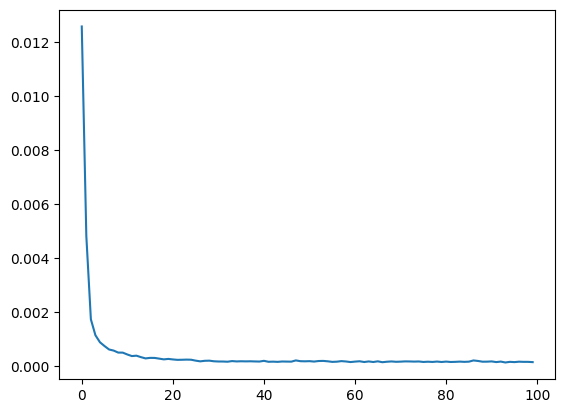

In [47]:
plt.plot(avg_losses) #plot of training losses

##Predicting test data using GRU

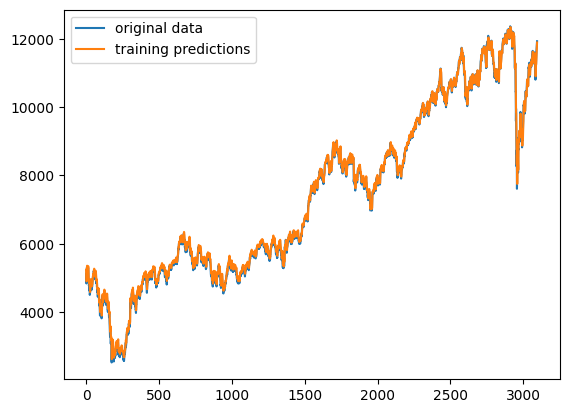

In [48]:
np.random.seed(48)
model.eval()
with torch.no_grad():
  closing_price = model(X_test.to(device))
  closing_price = scaler[0].inverse_transform(closing_price.cpu().numpy())
  training_price = model(X_train.to(device))
  valid_price = model(X_val.to(device))
  training_price = scaler[0].inverse_transform(training_price.cpu().numpy())
  valid_price = scaler[0].inverse_transform(valid_price.cpu().numpy())

training_price = [x[0] for x in training_price]
valid_price = [x[0] for x in valid_price]
plt.plot(list(scaler[0].inverse_transform(Y_train).tolist()+scaler[0].inverse_transform(Y_val).tolist()),label='original data')
plt.plot(list(training_price)+list(valid_price),label='training predictions')
plt.legend()
plt.show()

In [49]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_test,closing_price))

257.3335908958227

##Plotting predicted data using LSTM

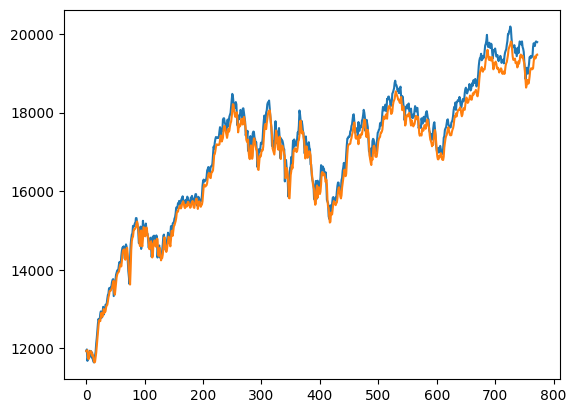

In [50]:
plt.plot(Y_test.tolist())
plt.plot(closing_price)
plt.show()